### Урок 5

#### Задание 1

Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)

In [72]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [149]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [74]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [75]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

In [76]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [77]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


In [78]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [79]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

In [80]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

## RandomForestClassifier

In [81]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

In [82]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

In [83]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.37, 0.26, 0.16, 0.02, 0.02, 0.67, 0.04, 0.12, 0.15, 0.75])

In [84]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [85]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))


Best Threshold=0.380000, F-Score=0.641, Precision=0.653, Recall=0.629


In [86]:
score_comparison = []

In [87]:
if ['RandomForestClassifier', precision[ix], recall[ix], thresholds[ix], fscore[ix]] not in score_comparison:
    score_comparison.append(['RandomForestClassifier', precision[ix], recall[ix], thresholds[ix], fscore[ix]])

In [88]:
score_comparison

[['RandomForestClassifier',
  0.6530612244897959,
  0.6286836935166994,
  0.38,
  0.6406406406406405]]

#### Вопрос 1: объясните своими словами смысл метрик Precison, Recall *
1. Какова их взаимосвязь и как с ними связан порог вероятности? 
2. Можно ли подобрать порог так, что recall будет равен 1? Что при этом будет с precision
3. Аналогичный вопрос про precision

<font color = blue> <b>Precision</b> - это доля верно предсказанных объектов первого класса (TP / (TP + FP)) в общем объеме объектов, которые алгоритм отнес к первому классу.<br>
<Recall> - это доля верно предсказанных объектов первого класса в общем объеме объектов действительно первого класса (TP / TP + FN).<br>

<b>Precision</b> - это доля объектов, определенных алгоритмом как первый класс и действительно являющихся первым классом, в общем количестве объектов, отнесенных алгоритмом к первому классу. Precision, равный 1, означает что алгоритм правильно определяет объекты первого класса и все объекты, которые алгоритм отнес к первому классу, действительно относятся к первому классу. То есть FP = 0. Но при этом алгоритм вполне может ошибочно отнести часть объектов первого класса к нулевому.
    
<b>Recall</b> - показывает какую долю объектов первого класса из общего количества объектов первого класса нашел алгоритм. Recall равный 1 означает, что алгоритм нашел все объекты первого класса. То есть FN = 0. Но при этом алгоритм вполне может ошибочно отнести часть объектов нулевого класса к первому.

<b>Порог вероятности</b> - это критерий, по которому алгоритм относит объект к первому или нулевому классу. Увеличивая порог вероятности, мы повышаем Precision (так как будет повышаться точность отнесения объекта к первому классу), но при этом у нас будет расти количество объектов первого класса ошибочно отнесенных к нулевому. То есть снижаться Recall. Таким образом, если Precision = 1, то Recall будет стремиться к нулю и наоборот. Пороги, при которых эти показатели близки 1 подобрать можно.  
    

In [89]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1832  159]
 [ 195  314]]


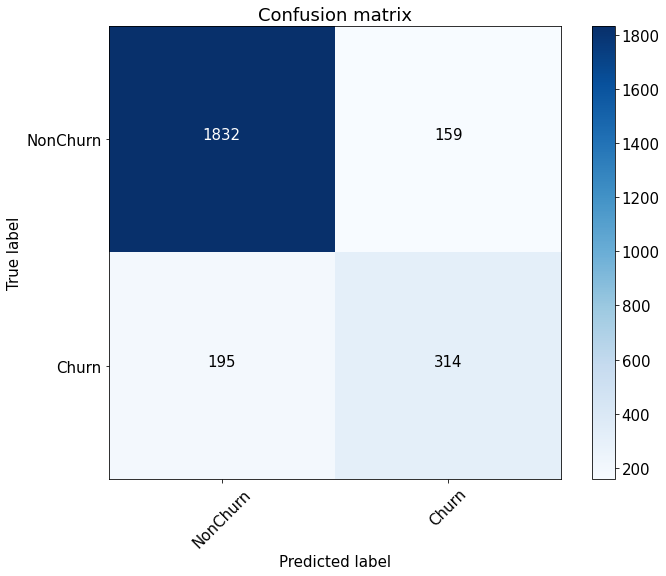

In [90]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

<font color = 'red'><b> Но я не поняла - почему, если взять данные из этой матрицы ошибок и попробовать посчитать Recall и Precision, то они не будут равны тому, что мы посчитали выше?

<b>Вопрос 2</b>: предположим, что на удержание одного пользователя у нас уйдет 1 доллар. При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара. Оцените качество модели выше с учетом этих данных и ответьте на вопрос, является ли она потенциально экономически целесообразной?

In [91]:
def economy_effect(TP, FP, FN, TN, price, cost):
    return TP*(price-cost), (TP-FP)*price-(TP*cost), (TP-FN)*(price-cost), (TP-TN)*(price-cost)  

In [168]:
comparison = []

In [169]:
if ['RandomForestClassifier', economy_effect(1832, 159, 195, 314, 2, 1)] not in comparison:
    comparison.append(('RandomForestClassifier', economy_effect(1832, 159, 195, 314, 2, 1)))

In [170]:
comparison

[('RandomForestClassifier', (1832, 1514, 1637, 1518))]

<font color = 'blue'> <b>True Pisitive</b><br>
    Выручка: 1832 х 2 = 3664 <br>
    Затраты: 1832 х 1 = 1832 <br>
    Прибыль: 3664 - 1832 = 1832 <br>
    Стоимость ошибки: 0 <br>
    <b>False positive</b> <br>
    Выручка: (1832 - 159) x 2 = 3346 <br>
    Затраты: 1832 х 1 = 1832 <br>
    Прибыль: 3346 - 1832 = 1514 <br>
    Стоимость ошибки: 159 <br>
    <b>False negative</b> <br>
    Выручка: (1832 - 195) x 2 = 3274 <br>
    Затраты: (1832 - 195) х 1 = 1637 <br>
    Прибыль: 3274 - 1637 = 1637 <br>
    Стоимость ошибки: 195 <br>
    <b>True negative</b> <br>
    Выручка: (1832 - 314) x 2 = 3036 <br>
    Затраты: (1832 - 314) х 1 = 1518 <br>
    Прибыль: 3036 - 1518 = 1518 <br>   

<Font color = 'red'><b> Единственное, я не поняла, как делать вывод? Модель будет являться потенциально экономически НЕ целесообразной, если хотя бы в одном (? или во всех? или в каких-то конкретных случаях?) будет убыток или как?

In [94]:
from sklearn.model_selection import GridSearchCV

params={'classifier__max_features':[0.3, 0.5, 0.7],
        'classifier__min_samples_leaf':[1, 2, 3],
        'classifier__max_depth':[None]
        }

In [96]:
#grid = GridSearchCV(pipeline,
#                    param_grid=params,
#                    cv=6,
#                    refit=False)

#search = grid.fit(X_train, y_train)
#search.best_params_

In [97]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(max_depth=None, max_features=0.5, 
                                          min_samples_leaf=3, random_state=42)),
])
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

Best Threshold=0.389431, F-Score=0.653, Precision=0.661, Recall=0.646
Confusion matrix, without normalization
[[1822  169]
 [ 181  328]]


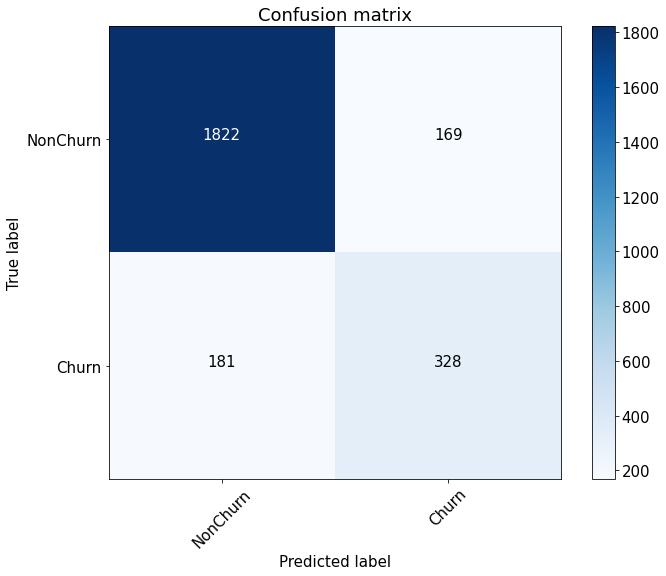

In [98]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [99]:
if ['RandomForestClassifier2', precision[ix], recall[ix], thresholds[ix], fscore[ix]] not in score_comparison:
    score_comparison.append(['RandomForestClassifier2', precision[ix], recall[ix], thresholds[ix], fscore[ix]])

In [171]:
if ['RandomForestClassifier2', economy_effect(1822, 169, 181, 328, 2, 1)] not in comparison:
    comparison.append(('RandomForestClassifier2', economy_effect(1822, 169, 181, 328, 2, 1)))

In [172]:
comparison

[('RandomForestClassifier', (1832, 1514, 1637, 1518)),
 ('RandomForestClassifier2', (1822, 1484, 1641, 1494))]

<font color = 'red'><b> Я не понимаю, с точки зрения экономического результата - первая модель была лучше (показатели прибыли почти в каждом варианте лучше, чем во второй модели). Но при этом с точки зрения GridSearch вторая модель построена на лучших параметрах. Как так?

## GradientBoostingClassifier

In [102]:
from sklearn.ensemble import GradientBoostingClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', GradientBoostingClassifier(random_state = 42)),
])

In [103]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

Best Threshold=0.408508, F-Score=0.646, Precision=0.704, Recall=0.597
Confusion matrix, without normalization
[[1863  128]
 [ 206  303]]


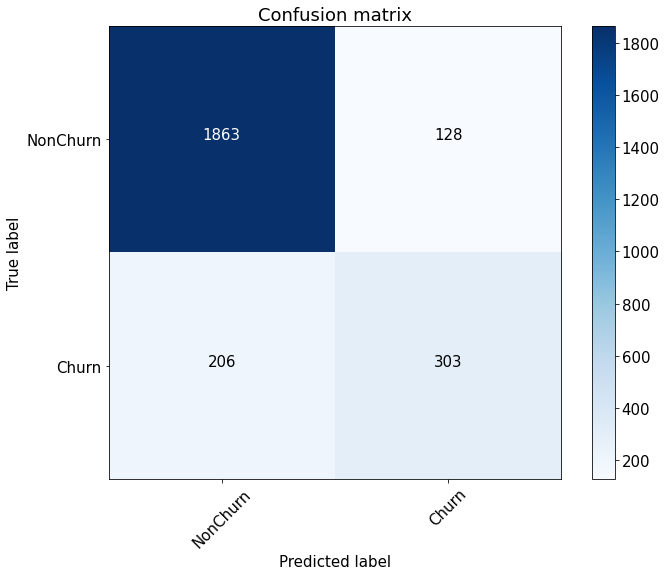

In [104]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [173]:
if ['GradientBoostingClassifier', economy_effect(1863, 128, 206, 303, 2, 1)] not in comparison:
    comparison.append(('GradientBoostingClassifier', economy_effect(1863, 128, 206, 303, 2, 1)))

In [174]:
comparison

[('RandomForestClassifier', (1832, 1514, 1637, 1518)),
 ('RandomForestClassifier2', (1822, 1484, 1641, 1494)),
 ('GradientBoostingClassifier', (1863, 1607, 1657, 1560))]

In [105]:
if ['GradientBoostingClassifier', precision[ix], recall[ix], thresholds[ix], fscore[ix]] not in score_comparison:
    score_comparison.append(['GradientBoostingClassifier', precision[ix], recall[ix], thresholds[ix], fscore[ix]])

In [106]:
score_comparison

[['RandomForestClassifier',
  0.6530612244897959,
  0.6286836935166994,
  0.38,
  0.6406406406406405],
 ['RandomForestClassifier2',
  0.6606425702811245,
  0.6463654223968566,
  0.389430735930736,
  0.6534260178748758],
 ['GradientBoostingClassifier',
  0.7037037037037037,
  0.5972495088408645,
  0.4085078904556646,
  0.6461211477151967]]

## LogisticRegression

In [129]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

In [150]:
df[continuous_columns].head(3)

,CreditScore,Age,Balance,NumOfProducts,EstimatedSalary
0,619,42,0.00,1,101348.88
1,608,41,83807.86,1,112542.58
2,502,42,159660.80,3,113931.57


In [151]:
df[continuous_columns] = preprocessing.MinMaxScaler().fit_transform(df[continuous_columns])

In [152]:
df[continuous_columns].head(3)

,CreditScore,Age,Balance,NumOfProducts,EstimatedSalary
0,0.538,0.324324,0.000000,0.000000,0.506735
1,0.516,0.310811,0.334031,0.000000,0.562709
2,0.304,0.324324,0.636357,0.666667,0.569654


In [153]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

In [154]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

In [155]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', LogisticRegression(random_state = 42)),
])

In [156]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('Geography',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))])),
                                                ('Gender',
                                                 Pipeline(steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Gender'))])),
                                                ('Tenure',
                                                 Pipeline(steps=[('selector',
           

<ipython-input-175-9c55906ef3fe>:3: RuntimeWarning: invalid value encountered in true_divide
  fscore = (2 * precision * recall) / (precision + recall)


Best Threshold=0.750600, F-Score=nan, Precision=0.000, Recall=0.000
Confusion matrix, without normalization
[[1990    1]
 [ 509    0]]


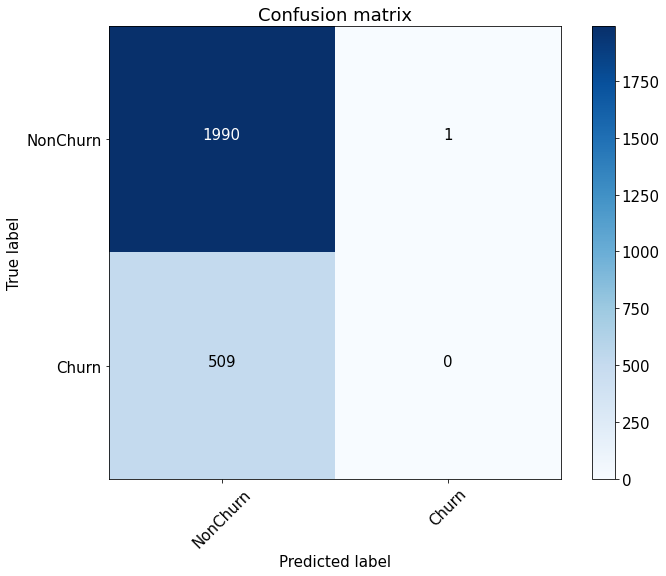

In [175]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

<font color = 'red'><b> Я не понимаю, что нужно сделать по другому. Не получается.  

In [159]:
if ['LogisticRegression', precision[ix], recall[ix], thresholds[ix], fscore[ix]] not in score_comparison:
    score_comparison.append(['LogisticRegression', precision[ix], recall[ix], thresholds[ix], fscore[ix]])

In [176]:
if ['LogisticRegression', economy_effect(1990, 1, 509, 0, 2, 1)] not in comparison:
    comparison.append(('LogisticRegression', economy_effect(1990, 1, 509, 0, 2, 1)))

In [177]:
comparison

[('RandomForestClassifier', (1832, 1514, 1637, 1518)),
 ('RandomForestClassifier2', (1822, 1484, 1641, 1494)),
 ('GradientBoostingClassifier', (1863, 1607, 1657, 1560)),
 ('LogisticRegression', (1990, 1988, 1481, 1990))]

#### Задание 2

Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)

In [160]:
df = pd.DataFrame(score_comparison, columns =['model', 'precision', 'recall', 'thresholds', 'fscore'])

In [161]:
df

,model,precision,recall,thresholds,fscore
0,RandomForestClassifier,0.653061,0.628684,0.380000,0.640641
1,RandomForestClassifier2,0.660643,0.646365,0.389431,0.653426
2,GradientBoostingClassifier,0.703704,0.597250,0.408508,0.646121
3,LogisticRegression,0.000000,0.000000,0.750600,NaN


<font color = 'red'> Поскольку у меня логистическая регрессия косячит - ее результаты учесть не получается. А как выбрать лучшую модель между RandomForestClassifier2 и CradienBoostingClassifier?

#### Задание 3

Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты.

In [178]:
comparison

[('RandomForestClassifier', (1832, 1514, 1637, 1518)),
 ('RandomForestClassifier2', (1822, 1484, 1641, 1494)),
 ('GradientBoostingClassifier', (1863, 1607, 1657, 1560)),
 ('LogisticRegression', (1990, 1988, 1481, 1990))]

<font color = 'blue'> Экономи лучше получается у бустинга и что удивительно у косячной логистической регрессии

#### Задание 4

(опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3

#### Задание 5

(опционально) Еще раз провести оценку экономической эффективности